
# Project: Design a machine-learning-based system for detecting text-based COVID-related fake news using BOW and a naive Bayes 

Dataset : New Combined Files

pip install pandas
pip install openpyxl

# 1. Dataset Preparation

### Let's start by parsing the HTML encoded characters in the datasets.


In [145]:
from openpyxl import load_workbook
import html

# Load the workbook and select the active worksheet
for i in range (1,9):
    wb = load_workbook(f'Group{i}.xlsx')
    ws = wb.active

    # Iterate over cells in the 'Content' column (assuming it's the first column)
    for row in range(1, ws.max_row + 1):
        cell = ws.cell(row=row, column=1)
        if isinstance(cell.value, str):
            cell.value = html.unescape(cell.value)

    # Save changes back to the file
    wb.save(f'Group{i}_modified.xlsx')

In [146]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/krystoffher/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## A. Group 1 

In [147]:
import pandas as pd
import matplotlib as plt
from bs4 import BeautifulSoup


df_1 = pd.read_excel("Group1_modified.xlsx")
df_1.dataframeName = 'Group 1'
df_1.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Not Fake = 0,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Final Pass,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fake = 1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TWEETS,NaN,AGATHA,EMMA,WILL,MINH,NaN,AGATHA,EMMA,WILL,...,NaN,NaN,NaN,NaN,NaN,Tweets,NaN,NaN,Note Fake,Fake
2,US regulators give full approval to Pfizer COV...,NaN,Not Fake,Fake,Not Fake,Fake,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Not Fake,NaN,NaN,NaN,NaN
3,"""Researchers in The Netherlands and Germany ha...",NaN,Not Fake,Fake,Not Fake,Fake,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Not Fake,NaN,NaN,NaN,NaN
4,"#Iran: #Coronavirus Fatalities Exceed 386,900 ...",NaN,Not Fake,Not Fake,Fake,Not Fake,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Not Fake,NaN,NaN,NaN,NaN


### We are only interested in two columns :
* The first one, the actual tweet content
* The 22nd, the final label

In [148]:
#Name these columns
df_1.columns=["Content","","","","","","","","","","","","","","","","","","","","","Label","","","",""]
#Keep only those
df_1 = df_1[['Content','Label']]
df_1.head()

,Content,Label
0,NaN,NaN
1,TWEETS,Tweets
2,US regulators give full approval to Pfizer COV...,Not Fake
3,"""Researchers in The Netherlands and Germany ha...",Not Fake
4,"#Iran: #Coronavirus Fatalities Exceed 386,900 ...",Not Fake


We still have two unused rows (indexes in pandas)

In [149]:
df_1 = df_1.drop(index=[0,1])
df_1.head()

,Content,Label
2,US regulators give full approval to Pfizer COV...,Not Fake
3,"""Researchers in The Netherlands and Germany ha...",Not Fake
4,"#Iran: #Coronavirus Fatalities Exceed 386,900 ...",Not Fake
5,(#PMOI/#MEK #Iran)&(#NCRI): #COVID Tehran Univ...,Not Fake
6,@AndyPan03390600 @IsoTupe @jonatho84952843 @ZO...,Not Fake


## Group 2

In [150]:
df_2 = pd.read_excel("Group2_modified.xlsx")
df_2.dataframeName = 'Group 2'
df_2.head()

,tweet_text,Unnamed: 1
0,"Dear #antivaxxer: When I say I'm spiritual, I ...",Not Fake
1,"You should defo get it, I got the Pfizer one ...",Not Fake
2,Lol literally nobody cares what some vegan an...,Not Fake
3,"Everyone knows that vaccines can, very occasio...",Not Fake
4,Done install microchip.\n#Pfizer,Fake


This one will be much easier to deal with, let's just rename the columns to keep it coherent, for now.

In [151]:
df_2.columns= ["Content","Label"]
df_2.head()

,Content,Label
0,"Dear #antivaxxer: When I say I'm spiritual, I ...",Not Fake
1,"You should defo get it, I got the Pfizer one ...",Not Fake
2,Lol literally nobody cares what some vegan an...,Not Fake
3,"Everyone knows that vaccines can, very occasio...",Not Fake
4,Done install microchip.\n#Pfizer,Fake


## Group 3

In [152]:
df_3 = pd.read_excel("Group3_modified.xlsx")
df_3.dataframeName = 'Group 3'
df_3.head()

,Tweet,Brian,Georgia,Raidah,Do we all agree?
0,"No, you can‚Äôt sue a manufacturer if you get ...",Not Fake,Not Fake,Not Fake,NaN
1,Norton Healthcare has updated their visitor po...,Not Fake,Not Fake,Not Fake,NaN
2,Not Yet Vaccinated? You Should Get Vaccinated!...,Not Fake,Not Fake,Not Fake,NaN
3,Nova Scotia Health will be running an outreach...,Not Fake,Not Fake,Not Fake,NaN
4,NSW‚Äôs total vaccine count is tonight sitting...,Not Fake,Not Fake,Not Fake,NaN


Here, we can see a column corresponding to the consensus. 
From the head of the dataset, it seems like all team members always agree. 
Let's check if that's true.

In [153]:
df_3['Do we all agree?'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Do we all agree?, dtype: float64

There are actually 2 tweets for which an agreement hasnt been reached. Looking at the dataset 'manually', we can see that Raidah's opinion is most consensual on these two tweets, so we'll keep that column as Label.

In [154]:
df_3.columns=['Content',"Brian",'Georgia','Label','Agreement']
df_3 = df_3[['Content','Label']]
df_3.head()

,Content,Label
0,"No, you can‚Äôt sue a manufacturer if you get ...",Not Fake
1,Norton Healthcare has updated their visitor po...,Not Fake
2,Not Yet Vaccinated? You Should Get Vaccinated!...,Not Fake
3,Nova Scotia Health will be running an outreach...,Not Fake
4,NSW‚Äôs total vaccine count is tonight sitting...,Not Fake


# Group 4 

In [155]:
df_4 = pd.read_excel("Group4_modified.xlsx")
df_4.dataframeName = 'Group 4'
df_4.columns = ['Content','Label']
df_4.head()

,Content,Label
0,"""A new vaccine from US company Novavax, which ...",Not Fake
1,This moron says the üíâ killing ppl are ‚Äúli...,Not Fake
2,Crazy! Three sisters die from Covid in one wee...,Not Fake
3,How's that mass civil disobedience campaign ag...,Fake
4,My two healthy relatives died only after injec...,Not Fake


# Group 5

In [156]:
df_5 = pd.read_excel("Group5_modified.xlsx")
df_5.dataframeName = 'Group 5'
df_5.columns = ['Content','Label']
df_5.drop(index=0)
df_5.head()

,Content,Label
0,NaN,NaN
1,- That's common for everyone.It wasn't like th...,not fake
2,.@BCNagesh_bjp is trying to appear that he is ...,fake
3,".@kprather88 , the aerosol expert, has suggest...",fake
4,‘You’re blowing this’: Melania criticises Trum...,fake


# Group 6

Sadly there are two sheets in Group6.xlsx, one of which explaining the thought process behind the labelling. I will start by splitting it in two different files.

In [157]:
""" # Load the Excel file
file_path = 'Group6_modified.xlsx'
excel_file = pd.ExcelFile(file_path)

# Extract names of all sheets
sheet_names = excel_file.sheet_names

# Check if there are at least two sheets
if len(sheet_names) < 2:
    raise ValueError("There should be at least two sheets in the Excel file.")

# Loop through each sheet and save it as a separate Excel file
for index, sheet_name in enumerate(sheet_names):
    # Read the sheet into a dataframe
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Define a new filename for the split Excel file
    new_file_name = f"{sheet_name}.xlsx"
    
    # Save the sheet data to a new Excel file
    df.to_excel(new_file_name, index=False)
    
    print(f"Sheet '{sheet_name}' saved to '{new_file_name}'.")
 """

' # Load the Excel file\nfile_path = \'Group6_modified.xlsx\'\nexcel_file = pd.ExcelFile(file_path)\n\n# Extract names of all sheets\nsheet_names = excel_file.sheet_names\n\n# Check if there are at least two sheets\nif len(sheet_names) < 2:\n    raise ValueError("There should be at least two sheets in the Excel file.")\n\n# Loop through each sheet and save it as a separate Excel file\nfor index, sheet_name in enumerate(sheet_names):\n    # Read the sheet into a dataframe\n    df = pd.read_excel(file_path, sheet_name=sheet_name)\n    \n    # Define a new filename for the split Excel file\n    new_file_name = f"{sheet_name}.xlsx"\n    \n    # Save the sheet data to a new Excel file\n    df.to_excel(new_file_name, index=False)\n    \n    print(f"Sheet \'{sheet_name}\' saved to \'{new_file_name}\'.")\n '

In [158]:
df_6 = pd.read_excel("Group6_modified.xlsx", sheet_name="FINAL Labelled Dataset")
df_6.dataframeName = 'Group 6'
df_6.columns = ['Label','Content']
# Switch columns values
m = df_6['Label'] != "NX"
df_6.loc[m, ['Label','Content']] = df_6.loc[m, ['Content','Label']].values
# Switch columns names
df_6.columns= ["Content","Label"]
df_6.head()

,Content,Label
0,#Pfizer admitting that #COVID-19 #vaccine #she...,FAKE
1,"We will keep reminding you of our rights,worth...",NOT FAKE
2,It is the duty of the govt. to provide the com...,NOT FAKE
3,The one Sunday where I actually have a legit e...,NOT FAKE
4,Caused not create!\n Viruses don’t just escape...,FAKE


# Group 7

In [159]:
df_7 = pd.read_excel("Group7_modified.xlsx")
df_7.dataframeName = 'Group 7'
df_7.columns = ['Content','Label']
df_7.drop(index=0)
df_7.head()

,Content,Label
0,We are still averaging >500 COVID deaths per d...,Not Fake
1,I know that there are several liberals who onl...,Not Fake
2,@AnnastaciaMP Lol and covid just disappeared j...,Fake
3,@ProudSocialist @tiffanyjewel10 Nothing would ...,Fake
4,How about a little inquiry into your governmen...,Fake


# Group 8
I need to get rid of the first few lines

In [160]:
df_8 = pd.read_excel("Group8_modified.xlsx")
df_8.dataframeName = 'Group 8'
df_8.columns = ['Content','Label']
df_8.head()

,Content,Label
0,RED = FAKE,NaN
1,BLUE = NOT FAKE,NaN
2,NaN,NaN
3,Tweet Text,NaN
4,"According to Chynna Ortaleza, the lockdown aff...",Not Fake


# Group 9

In [161]:
df_9 = pd.read_excel("Group9_modified.xlsx")
df_9.dataframeName = 'Group 9'
df_9.columns=['Number',"Content",'Label','IRR']
df_9 = df_9[['Content','Label']]
df_9.head()

,Content,Label
0,Reported that nasal Covid19 vaccine that using...,Fake
1,22 people died of COVID-19,Not Fake
2,@MTA is honoring the 400+ employees who died f...,Not Fake
3,"Man allegedly died from COVID-19 vaccine, fami...",Not Fake
4,"With all due respect to the Queen, kinda feels...",Not Fake


# Merging the Dataset
Now all the dataset have the same formats, let's merge them before preprocessing

In [162]:
merged_df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6,df_7, df_8, df_9], ignore_index=True)
merged_df.describe()

,Content,Label
count,5205,5200
unique,4304,19
top,BREAKING: The $12 million DeSantis spent on hi...,Not Fake
freq,48,2669


In [163]:
df_6.describe()

,Content,Label
count,601,600
unique,599,4
top,Xi will meet Putin on his first go to outdoors...,NOT FAKE
freq,2,322


# Preprocessing

1. Converting the labels to lower case
2. Converting the label to 0 or 1
3. Getting rid of special characters in the content
4. Implementing Bag of Words

1. Converting the labels to lower case

In [164]:
merged_df = merged_df[merged_df['Label'].apply(lambda x: isinstance(x, (str, bytes)))]
merged_df['Label'] = merged_df['Label'].apply(str.lower)
merged_df.head()

,Content,Label
0,US regulators give full approval to Pfizer COV...,not fake
1,"""Researchers in The Netherlands and Germany ha...",not fake
2,"#Iran: #Coronavirus Fatalities Exceed 386,900 ...",not fake
3,(#PMOI/#MEK #Iran)&(#NCRI): #COVID Tehran Univ...,not fake
4,@AndyPan03390600 @IsoTupe @jonatho84952843 @ZO...,not fake


2. Converting the label to 0 or 1

In [165]:
def binarise(label):
    if label.replace(" ", "") == "fake" :
        return 1
    elif (label.replace(" ", "") == "notfake") or label.replace(" ", "") == "not-fake" :
        return 0
    else :
        return 2

merged_df['Binarised Label'] = merged_df['Label'].apply(binarise)
merged_df['Binarised Label'].value_counts()


Binarised Label
0    3474
1    1722
2       4
Name: count, dtype: int64

### We see that there are 4 labels that are not "fake" or "not fake"
Let's look at those outliers

In [166]:
merged_df["Label"].value_counts()

Label
not fake                    3430
fake                        1688
not fake                      42
fake                          34
not-fake                       2
unknown                        2
fake but partically true       1
no fake                        1
Name: count, dtype: int64

It appears that all of these outliers corresponds to tweets that haven't successfully been labeled."

# Stemming, Tokenization... 

stopwords : https://gist.githubusercontent.com/sebleier/554280/raw/7e0e4a1ce04c2bb7bd41089c9821dbcf6d0c786c/NLTK's%2520list%2520of%2520english%2520stopwords

In [171]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now',"#ff", "ff", "rt"]

In [179]:
# Make sure all the content column is made of strings

merged_df["Content"] = merged_df["Content"].apply(str)

### Next part is inspired by : https://github.com/NakulLakhotia/Hate-Speech-Detection-in-Social-Media-using-Python/blob/master/final_customization.ipynb

In [181]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stemmer = PorterStemmer()

def preprocess(tweet):
    # Removal of extra spaces
    tweet = re.sub(r'\s+', ' ', tweet)
    # Removal of @name [mention]
    tweet = re.sub(r'@[\w\-]+', ' ', tweet)
    # Removal of links [https://abc.com]
    tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', tweet)
    # Removal of punctuations and numbers
    tweet = re.sub(r'[^a-zA-Z]', ' ', tweet)
    # Remove whitespace with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    # Remove leading and trailing whitespace
    tweet = tweet.strip()
    # Removal of capitalization
    tweet = tweet.lower()
    # Tokenizing
    tokenized_tweet = tweet.split()
    # Stopwords removal and stemming
    processed_tweet = []
    for word in tokenized_tweet:
        if word not in stopwords:
            stemmed_word = stemmer.stem(word)
            processed_tweet.append(stemmed_word)
    # Join the processed words back into a single string
    return ' '.join(processed_tweet)

merged_df['processed_tweets'] = merged_df["Content"].apply(preprocess)  

print(merged_df[["Content","processed_tweets"]].head(10))

                                             Content  \
0  US regulators give full approval to Pfizer COV...   
1  "Researchers in The Netherlands and Germany ha...   
2  #Iran: #Coronavirus Fatalities Exceed 386,900 ...   
3  (#PMOI/#MEK #Iran)&(#NCRI): #COVID Tehran Univ...   
4  @AndyPan03390600 @IsoTupe @jonatho84952843 @ZO...   
5  @DailyMailUK Not needed, even if a healthy chi...   
6  @JohnPas4285 @BuffaloBills @OxfordPennant Ther...   
7  Bigtime vaccine FAILURES. 87 fully vaccinated ...   
8  Breakthrough! BS vaccine not working! Dumb sci...   
9  Casar also pushes back on this week\'s "frustr...   

                                    processed_tweets  
0  us regul give full approv pfizer covid vaccin ...  
1  research netherland germani warn pfizer bionte...  
2  iran coronaviru fatal exceed citiestehran univ...  
3  pmoi mek iran ncri covid tehran univers number...  
4  proven death caus vaccin need read inform enti...  
5  need even healthi child get covid recov gain n... 

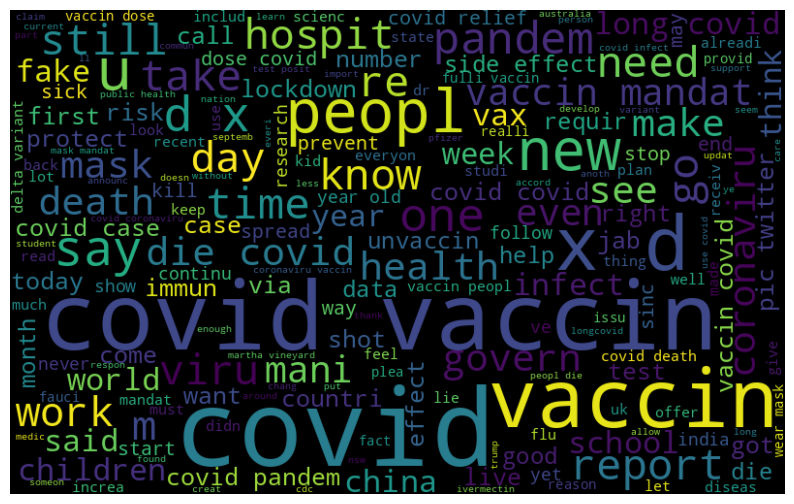

In [185]:
# visualizing which of the word is most commonly used in the twitter dataset
from wordcloud import WordCloud
import matplotlib.pyplot  as plt
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in merged_df['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()